In [1]:
import numpy as np
import pandas as pd

import utils

import matplotlib
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns

## plot comparison of confidence interval widths

In [2]:
df = pd.read_csv('native-010423-delta0.09.csv', index_col=0)
df

,q,n,width,covered,estimator,lower,upper
0,0.50,49,3.000000,1,prediction-powered,4.100000,7.100000
1,0.50,49,2.247277,0,classical,3.284341,5.531618
2,0.50,49,3.000000,1,prediction-powered,4.700000,7.700000
3,0.50,49,3.157921,1,classical,3.931617,7.089539
4,0.50,49,4.100000,1,prediction-powered,4.100000,8.200000
...,...,...,...,...,...,...,...
29995,0.75,1000,0.867352,1,classical,10.133627,11.000979
29996,0.75,1000,0.900000,1,prediction-powered,9.800000,10.700000
29997,0.75,1000,0.883278,1,classical,9.918705,10.801983
29998,0.75,1000,0.700000,1,prediction-powered,10.000000,10.700000


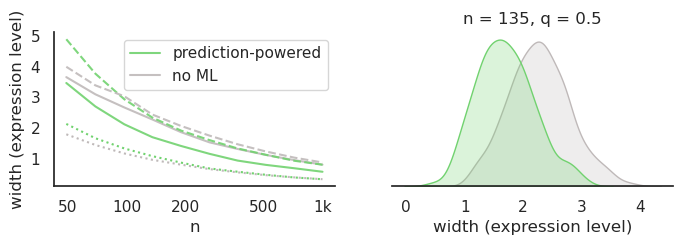

In [5]:
save = True
n_to_plot = 135
c_cl, c_pp = "#BFB9B9", "#71D26F"
ns = np.logspace(np.log10(50), np.log10(1000), num=10, base=10).astype(int)
ns_xticks = [50, 100, 200, 500, 1000]
ns_xticklabels = [50, 100, 200, 500, '1k']
plot_df = df.loc[(df.q == 0.5) & (df.n == n_to_plot)]


fig, axs = plt.subplots(1, 2, figsize=(8, 2))

for q, ls in zip([0.25, 0.5, 0.75], [':', '-', '--']):
    dfqn = df.loc[df.q == q]
    wcl_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'classical')].width.mean()for n in ns])
    wpp_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'prediction-powered')].width.mean()for n in ns])
    axs[0].plot(
        ns, wpp_n,
        label='prediction-powered' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_pp)
    axs[0].plot(
        ns, wcl_n,
        label='no ML' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_cl)
    
axs[0].set_xscale('log')
axs[0].set_xticks(ns_xticks)
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels(ns_xticklabels)
axs[0].set_xlabel('n');
axs[0].set_ylabel('width (expression level)')
axs[0].legend();
sns.despine(ax=axs[0],top=True,right=True)

my_palette = sns.color_palette([c_pp, c_cl], 2)
sns.set_theme(style="white", palette=my_palette)
kde = sns.kdeplot(
    plot_df, x="width", hue="estimator", hue_order=["prediction-powered", "classical"],
    fill=True, ax=axs[1])
kde.get_legend().remove()
sns.despine(ax=axs[1],top=True,right=True,left=True)
axs[1].set_xlabel("width (expression level)")
axs[1].set_ylabel('')
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_title('n = {}, q = 0.5'.format(n_to_plot));
if save:
    plt.savefig('figures/widths.png', dpi=300, bbox_inches='tight')
plt.show()

## plot one example set of intervals

/home/clarafy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error in 3.6


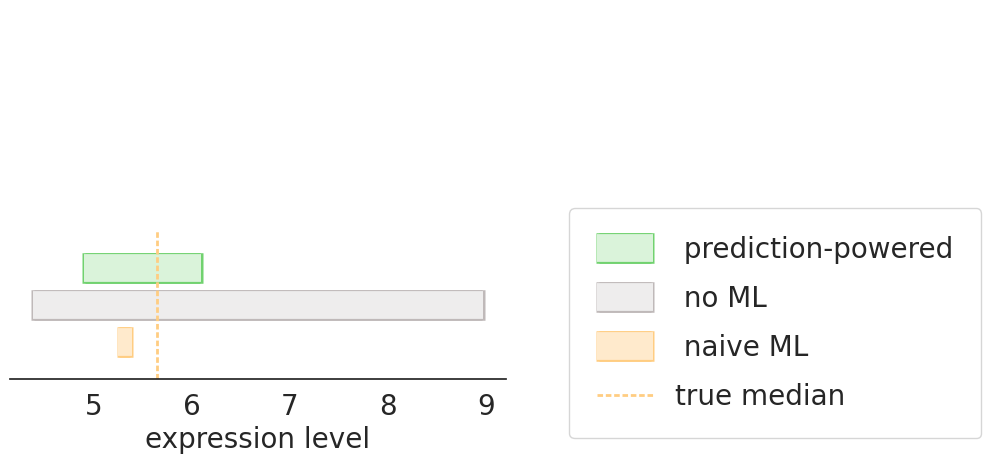

In [13]:
q = 0.5
n = 97
tmp = df.loc[(df.q == q) & (df.n == n)]
cl_df = tmp[1::2]
pp_df = tmp[0::2]
trial = 87
save = True

# true median gene expression
data_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
theta_star = np.quantile(data_df.measured, 0.5)

# naive confidence interval
f_all = data_df.predicted.to_numpy()
f_all = 20 * (f_all - np.min(f_all)) / (np.max(f_all) - np.min(f_all))
ci_naive = utils.get_classical_ci(f_all, 0.5, 0.1)

ci_pp = [pp_df.iloc[trial].lower, pp_df.iloc[trial].upper]
ci_cl = [cl_df.iloc[trial].lower, cl_df.iloc[trial].upper]

plt.figure(figsize=(6.4,4.8))
plt.plot(
    ci_pp,[0.3, 0.3],
    linewidth=20, color="#DAF3DA", solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#71D26F"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#71D26F"),
        pe.Normal()
    ],
    label=' prediction-powered'
)
plt.plot(
    ci_cl, [0.2, 0.2],
    linewidth=20, color="#EEEDED",
    solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#BFB9B9"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#BFB9B9"),
        pe.Normal()
    ],
    label=' no ML'
)
plt.plot(
    ci_naive, [0.1, 0.1],
    linewidth=20, color="#FFEACC", 
    solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#FFCD82"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#FFCD82"),
        pe.Normal()
    ],
    label=' naive ML'
)
plt.plot(
    [theta_star, theta_star], [0, 0.4], linestyle='--', dashes=(2, 1), linewidth=2,
    label="true median", color="#FFCD82"
)
plt.xlabel("expression level", fontsize=20)
plt.yticks([], labels=[])
plt.xticks([5, 6, 7, 8, 9], fontsize=20)
plt.ylim([0,1])
leg = plt.legend(fontsize=20, borderpad=1, labelspacing = 0.75, bbox_to_anchor=[1.1,0.5])
sns.despine(ax=plt.gca(),top=True,right=True,left=True)

if save:
    plt.savefig('./figures/intervals.pdf', ppi=300, bbox_inches='tight')
plt.show()